In [55]:
#Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Import all scikit-learn modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import hamming_loss
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

#Set some global options
pd.set_option('max_columns',100) #Its nice to see all columns

#Set some global plot defaults
sns.set(rc={"figure.figsize": (15, 8), 'legend.fontsize': 18}) # figsize and leg fontsize of seaborn plots
plt.rc('axes',  labelsize=18)                                  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)                                  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)                                  # fontsize of the tick labels

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [56]:
#util func to print out metrics
def print_scores(model):
    y_pred = model.predict(x_test)
    y_pred_prob = model.predict_proba(x_test)[:,1]
    
    rsq = model.score(x_train, y_train)
    mse = mean_squared_error(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    ham = hamming_loss(y_test, y_pred)
    
    print('Score\t\t\tValue')
    print(40*'-')
    print('%-20s\t%f' % ('R^2', rsq))
    print('%-20s\t%f' % ('Mean Sq Error', mse))
    print('%-20s\t%f' % ('ROC AUC', auc))
    print('%-20s\t%f\n' % ('Hamming Loss', ham))
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))    #Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    #Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

## Read in the current cleaned data

In [57]:
df = pd.read_pickle('data/cleaned_df.pkl')
df['round'] = df['round'].astype(int)
df['year'] = df['year'].astype(int)

df.head()

,name,year,college,position,height,weight,fortyyd,vertical,bench,threecone,shuttle,broad,wonderlic,nflgrade,arms,hands,team,round,pick,overall,positiongroup
0,Ameer Abdullah,2015,Nebraska,RB,69.0,205.0,4.60,42.5,24.0,6.79,3.95,130.0,25.0,5.9,32.5,9.5,Lions,2,22.0,54.0,BA
1,Nelson Agholor,2015,Southern California,WR,72.0,198.0,4.42,33.0,12.0,7.19,4.35,114.0,25.0,5.6,32.5,9.5,Eagles,1,20.0,20.0,RE
2,Jay Ajayi,2015,Boise State,RB,72.0,221.0,4.57,39.0,19.0,7.10,4.10,121.0,25.0,6.0,32.5,9.5,Dolphins,5,13.0,149.0,BA
3,Kwon Alexander,2015,LSU,OLB,73.0,227.0,4.55,36.0,24.0,7.14,4.20,121.0,25.0,5.4,32.5,9.5,Buccaneers,4,25.0,124.0,LB
4,Mario Alford,2015,West Virginia,WR,68.0,180.0,4.43,34.0,13.0,6.64,4.07,121.0,25.0,5.3,32.5,9.5,Bengals,7,21.0,238.0,RE


## Prep dataframe for modeling

In [58]:
thedf = df.copy()
thedf['drafted'] = thedf['round'] > 0
thedf.drop(['name','college','position','pick','overall','team'], axis=1, inplace=True)
thedf.drop('round', axis=1, inplace=True)
thedf = pd.get_dummies(thedf, drop_first=True)
thedf

,year,height,weight,fortyyd,vertical,bench,threecone,shuttle,broad,wonderlic,nflgrade,arms,hands,drafted,positiongroup_DB,positiongroup_DL,positiongroup_LB,positiongroup_OL,positiongroup_QB,positiongroup_RE,positiongroup_ST
0,2015,69.0,205.0,4.60,42.5,24.0,6.79,3.95,130.0,25.0,5.9,32.5,9.5,True,0,0,0,0,0,0,0
1,2015,72.0,198.0,4.42,33.0,12.0,7.19,4.35,114.0,25.0,5.6,32.5,9.5,True,0,0,0,0,0,1,0
2,2015,72.0,221.0,4.57,39.0,19.0,7.10,4.10,121.0,25.0,6.0,32.5,9.5,True,0,0,0,0,0,0,0
3,2015,73.0,227.0,4.55,36.0,24.0,7.14,4.20,121.0,25.0,5.4,32.5,9.5,True,0,0,1,0,0,0,0
4,2015,68.0,180.0,4.43,34.0,13.0,6.64,4.07,121.0,25.0,5.3,32.5,9.5,True,0,0,0,0,0,1,0
5,2015,72.0,221.0,4.53,35.5,11.0,6.96,4.28,121.0,25.0,5.3,32.5,9.5,True,0,0,0,0,0,0,0
6,2015,72.0,218.0,4.56,35.5,21.0,7.09,4.03,122.0,25.0,5.5,32.5,9.5,True,1,0,0,0,0,0,0
7,2015,73.0,187.0,4.54,33.0,13.0,7.19,4.35,114.0,25.0,5.5,32.5,9.5,False,0,0,0,0,0,1,0
8,2015,78.0,294.0,4.97,30.0,21.0,7.20,4.19,111.0,25.0,5.6,32.5,9.5,True,0,1,0,0,0,0,0
9,2015,77.0,244.0,4.72,33.0,21.0,7.19,4.35,114.0,25.0,5.5,32.5,9.5,False,0,0,0,0,0,1,0


In [59]:
target = 'drafted'
x = thedf.drop(target, axis=1).values
y = thedf[target].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1221, stratify=y)

## Initial LogReg

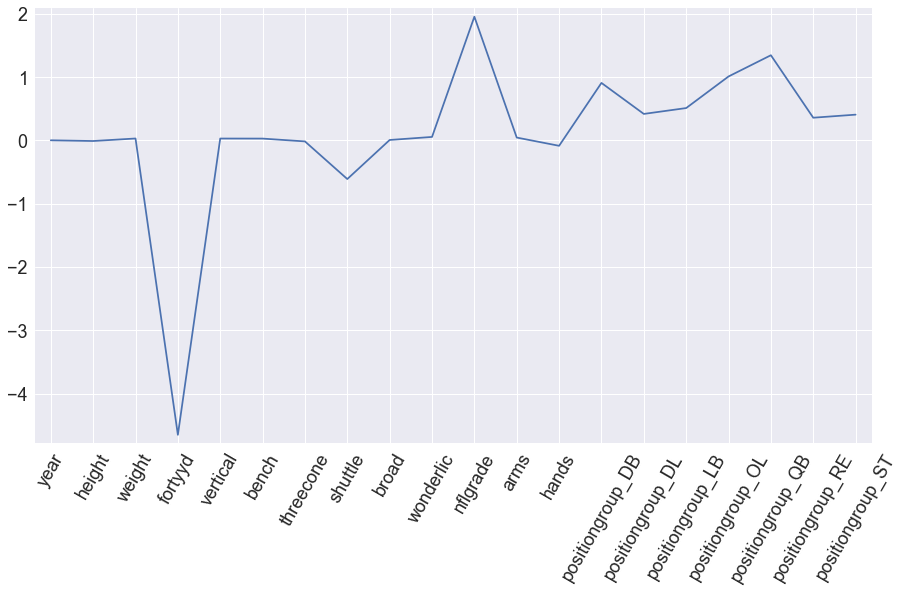

In [60]:
logreg = LogisticRegression(penalty="l2", C=1e7) #No regularization

logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

# Plot the coefficients
df_columns=thedf.drop(target, axis=1).columns.values
plt.plot(range(len(df_columns)), logreg.coef_.reshape(-1,1))
plt.xticks(range(len(df_columns)), df_columns, rotation=60)
plt.margins(0.02)
plt.show()

## LogReg with LASSO

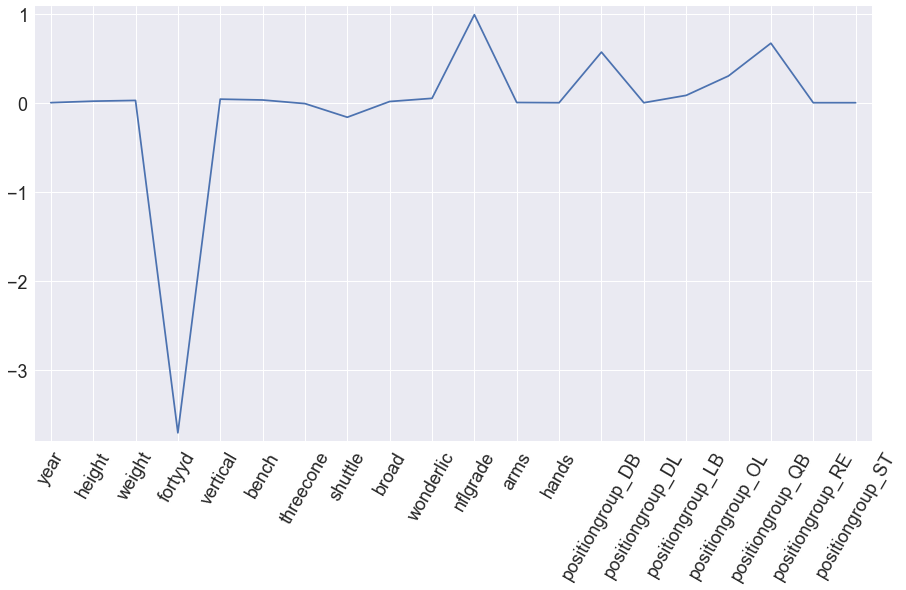

In [61]:
logreg = LogisticRegression(penalty="l1", C=0.1) #LASSO with relatively high penalty

logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

# Plot the coefficients
df_columns=thedf.drop(target, axis=1).columns.values
plt.plot(range(len(df_columns)), logreg.coef_.reshape(-1,1))
plt.xticks(range(len(df_columns)), df_columns, rotation=60)
plt.margins(0.02)
plt.show()

-----------

## LogReg GridSearch 

In [62]:
#Create the hyperparameter grid
c_space = np.logspace(-3, 3, 15) #-5, 8
param_grid = {'logreg__C': c_space, 'logreg__penalty': ['l1', 'l2']}

#New LogReg object
logreg2 = LogisticRegression()

#Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('logreg', logreg2)]
pipeline = Pipeline(steps)

logreg_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring=make_scorer(roc_auc_score, greater_is_better=True))

In [63]:
#Fit it to the training data
logreg_cv.fit(x_train, y_train)

#Print the optimal parameters and best score
print("Best Logistic Reg Parameters {}".format(logreg_cv.best_params_))

Best Logistic Reg Parameters {'logreg__C': 7.1968567300115138, 'logreg__penalty': 'l1'}


### Get 'best' LogReg

Score			Value
----------------------------------------
R^2                 	0.700208
Mean Sq Error       	0.318371
ROC AUC             	0.697627
Hamming Loss        	0.318371

             precision    recall  f1-score   support

      False       0.61      0.33      0.43       437
       True       0.70      0.88      0.78       766

avg / total       0.67      0.68      0.65      1203

[[145 292]
 [ 91 675]]


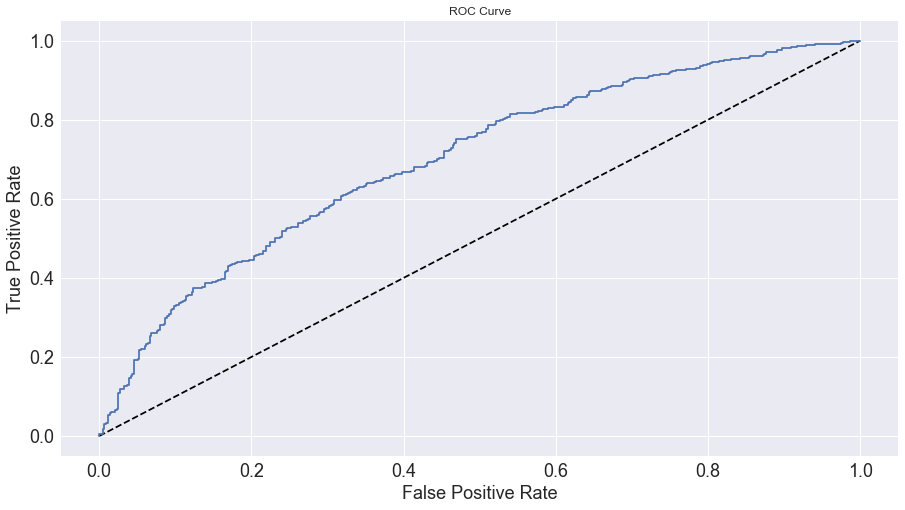

In [64]:
#Create new 'best params' logreg
logreg_best = LogisticRegression(penalty=logreg_cv.best_params_['logreg__penalty'], 
                                 C=logreg_cv.best_params_['logreg__C'])
logreg_best.fit(x_train,y_train)

print_scores(logreg_best)

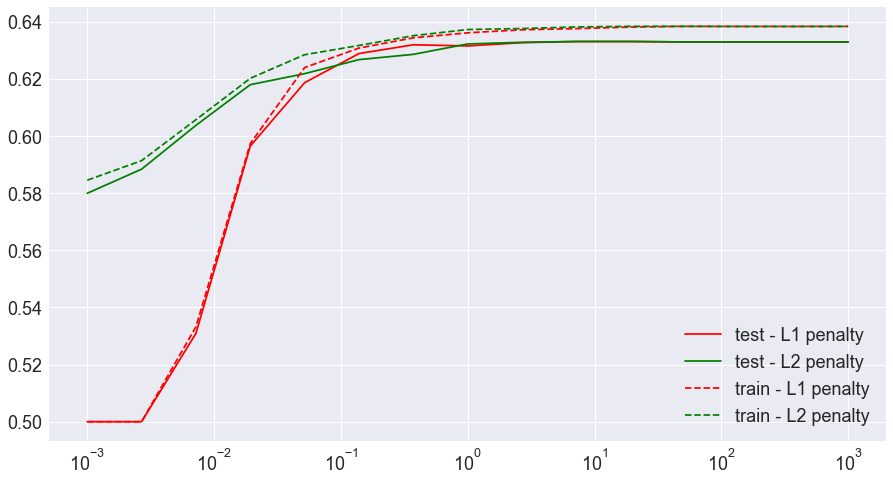

In [65]:
def plotCVResults(results):
    #Plot the results of the CV fit
    res = pd.DataFrame(results)
    
    str_param1 = 'param_logreg__penalty'
    str_param2 = 'param_logreg__C'
    
    n_penalty = res.groupby(str_param1).ngroups
    n_params  = res.groupby(str_param2)['mean_fit_time'].count()
    #print(n_penalty)
    
    test = res.pivot(index = str_param1, columns = str_param2, values='mean_test_score').T
    train= res.pivot(index = str_param1, columns = str_param2, values='mean_train_score').T
    #print((test))
    #print(train)
    plt.plot(test.l1, '-r', label='test - L1 penalty')
    plt.plot(test.l2, '-g', label='test - L2 penalty')
    plt.plot(train.l1, '--r', label='train - L1 penalty')
    plt.plot(train.l2, '--g', label='train - L2 penalty')
    plt.xscale('log')
    plt.legend()
    plt.show()
    
    
plotCVResults(logreg_cv.cv_results_)    

-----------

## Dummy Classifier 

Score			Value
----------------------------------------
R^2                 	0.480249
Mean Sq Error       	0.495428
ROC AUC             	0.500000
Hamming Loss        	0.495428

             precision    recall  f1-score   support

      False       0.37      0.50      0.42       437
       True       0.64      0.51      0.57       766

avg / total       0.54      0.50      0.51      1203

[[218 219]
 [377 389]]


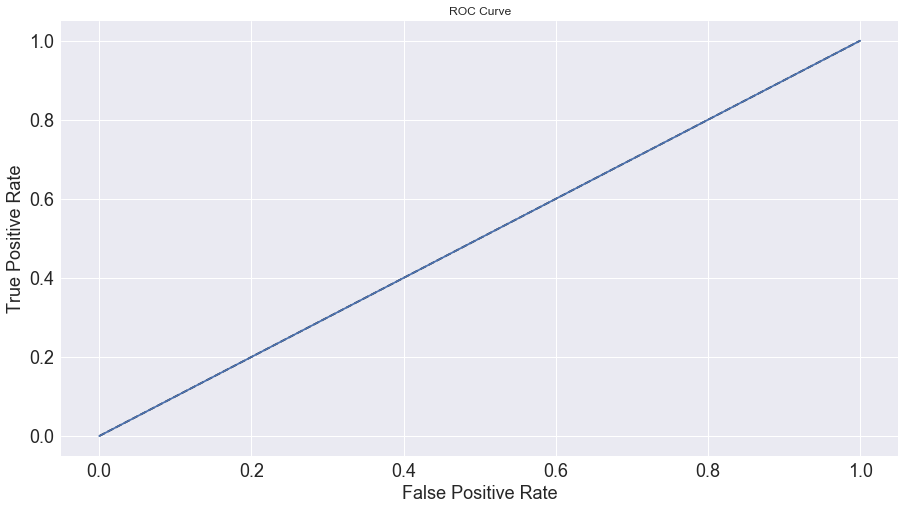

In [66]:
dummy = DummyClassifier('uniform')
dummy.fit(x_train, y_train)

print_scores(dummy)

-----------

## KNN GridSearch 

In [67]:
#Create the hyperparameter grid
param_grid = {'knn__n_neighbors': range(5,11,1), 'knn__p': range(1,3,1)}

#New KNN object
knn = KNeighborsClassifier()

#Setup the pipeline
steps = [('scaler', StandardScaler()),
         ('knn', knn)]
pipeline = Pipeline(steps)

knn_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring=make_scorer(roc_auc_score, greater_is_better=True))

In [68]:
# Fit it to the training data
knn_cv.fit(x_train,y_train)

# Print the optimal parameters and best score
print("Tuned KNN Parameters {}".format(knn_cv.best_params_))

Tuned KNN Parameters {'knn__p': 2, 'knn__n_neighbors': 10}


### Get 'best' KNN

Score			Value
----------------------------------------
R^2                 	0.705613
Mean Sq Error       	0.388196
ROC AUC             	0.598675
Hamming Loss        	0.388196

             precision    recall  f1-score   support

      False       0.45      0.33      0.38       437
       True       0.67      0.77      0.72       766

avg / total       0.59      0.61      0.60      1203

[[145 292]
 [175 591]]


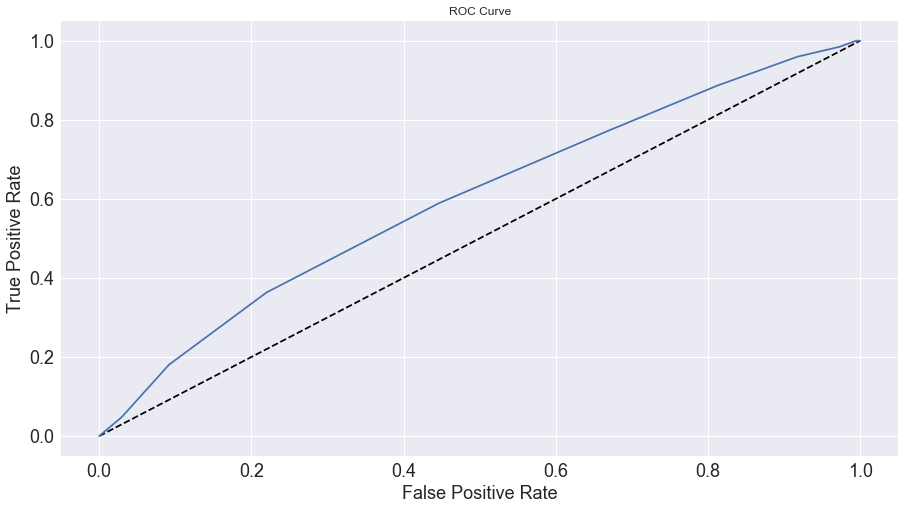

In [69]:
knn_best = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['knn__n_neighbors'], 
                              p=knn_cv.best_params_['knn__p'])
knn_best.fit(x_train,y_train)

print_scores(knn_best)